In [1]:
import cryo
import polars as pl
import binascii
import web3
import json
from eth_abi import decode
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

In [2]:
# The multical cantract address, but we also need ABI
MULTICALL3_ADDRESS = '0xcA11bde05977b3631167028862bE2a173976CA11'
MULTICALL3_ABI=json.loads('[{"inputs":[{"internalType":"bool","name":"requireSuccess","type":"bool"},{"components":[{"internalType":"address","name":"target","type":"address"},{"internalType":"bytes","name":"callData","type":"bytes"}],"internalType":"struct Multicall3.Call[]","name":"calls","type":"tuple[]"}],"name":"tryAggregate","outputs":[{"components":[{"internalType":"bool","name":"success","type":"bool"},{"internalType":"bytes","name":"returnData","type":"bytes"}],"internalType":"struct Multicall3.Result[]","name":"returnData","type":"tuple[]"}],"stateMutability":"payable","type":"function"}]')

UNIV2_ETH_USDC= '0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc'
SUSHIV2_USDC_ETH='0x397FF1542f962076d0BFE58eA045FfA2d347ACa0'
UNIV3_USDC_ETH='0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640'
UNIV3_WBTC_ETH = '0xCBCdF9626bC03E24f779434178A73a0B4bad62eD'

In [3]:
# Function Signatures 4 bytes
getBlocknumber_4b = '42cbb15c'
getBloclTimestamp_4b= '0f28c97d'
getReserves_4b = '0902f1ac'
slot0_4b = '3850c7bd'

In [4]:
# Functions
def bytes_to_hexstr(b: any) -> str:
    if isinstance(b,list):
        return [bytes_to_hexstr(a) for a in b]
    return '0x' + b.hex()

def decode_outputdata_uniV2V3_price(b: bytes) -> list[float]:
    aggregated_data_uniV2V3 = decode(['(bool,bytes)[]'], b)[0]

    # UNI-V2
    ethusdc_reserves_raw = aggregated_data_uniV2V3[0]
    [eth_bal, usdc_bal, time ] = decode(['uint112','uint112','uint32'], ethusdc_reserves_raw[1])

    eth_usdc_price_v2 = (eth_bal / usdc_bal)*1e12
    # print(f"ETH/USDC: {eth_usdc_price}")

    # SUSHI-V2
    ethusdc_reserves_raw = aggregated_data_uniV2V3[0]
    [eth_bal, usdc_bal, time ] = decode(['uint112','uint112','uint32'], ethusdc_reserves_raw[1])

    eth_usdc_price_sushi = (eth_bal / usdc_bal)*1e12

    # UNI-V3
    # slot0():
    # sqrtPriceX96 uint160, tick int24, observationIndex uint16, observationCardinality uint16, observationCardinalityNext uint16, feeProtocol uint8, unlocked bool
    # 'uint160', 'int24', 'uint16', 'uint16', 'uint16', 'uint8', 'bool'

    usdc_eth_slot0_raw = aggregated_data_uniV2V3[1]
    usdc_eth_slot0_sqrt_ratioX96 = decode(['uint160', 'int24', 'uint16', 'uint16', 'uint16', 'uint8', 'bool'], usdc_eth_slot0_raw[1])[0]
    usdc_eth_price = usdc_eth_slot0_sqrt_ratioX96**2 / 2**192 /1e12
    eth_usdc_price_v3 = 1/usdc_eth_price
    # print(f"WBTC/ETH: { wbtc_eth_price}")
    # print(f"ETH/WBTC: { eth_wbtc_price}")

    # Timestamp
    timestamp_raw = aggregated_data_uniV2V3[-1]
    timestamp = int(timestamp_raw[1].hex(),16)
    
    return [eth_usdc_price_v2, eth_usdc_price_v3, eth_usdc_price_sushi, timestamp]

In [5]:
# web3 instance, function from web3py
w3 = web3.Web3()
m3 = w3.eth.contract(address = MULTICALL3_ADDRESS, abi=MULTICALL3_ABI)

In [6]:
# Arguments fro the tryAggregate Fuunction
aggregate_calldata = [
    [
        UNIV2_ETH_USDC,
        f'0x{getReserves_4b}',
    ],
    [
        UNIV3_USDC_ETH,
        f'0x{slot0_4b}',
    ],
    [
        SUSHIV2_USDC_ETH,
        f'0x{getReserves_4b}',
    ],
    [
        MULTICALL3_ADDRESS,
        f'0x{getBloclTimestamp_4b}'
    ],
]

In [7]:
aggregate_calldata

[['0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc', '0x0902f1ac'],
 ['0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640', '0x3850c7bd'],
 ['0x397FF1542f962076d0BFE58eA045FfA2d347ACa0', '0x0902f1ac'],
 ['0xcA11bde05977b3631167028862bE2a173976CA11', '0x0f28c97d']]

In [8]:
# Generate calldate (the input) via m3 Multicall3 encode ABIfor cryo 
calldata = m3.encode_abi("tryAggregate", args=[False, aggregate_calldata])

In [9]:
#  Call data passed to cryo collect 
cryo_kwargs = {
    'rpc': 'https://eth.merkle.io',
    'blocks': ['-1000:latest'], 
}
            
eth_call_uni_df = cryo.collect(
    'eth_calls',
    to_address = [MULTICALL3_ADDRESS],
    call_data=[calldata],
     output_format="polars",
    **cryo_kwargs,
)

In [10]:
output_data=eth_call_uni_df['output_data'][0]

In [11]:
# It returns binary output
aggregated_data_uniV2V3 = decode(['(bool,bytes)[]'], output_data)[0]

In [12]:
decode_outputdata_uniV2V3_price(output_data)

[2438.4992261512984, 2434.4890564622597, 2438.4992261512984, 1740584627]

In [13]:
prices = [decode_outputdata_uniV2V3_price(x) for x in eth_call_uni_df['output_data'].to_list()]

### Prices list to dataframe  and Time as DF index

In [14]:
df_prices = pd.DataFrame(prices, columns=['eth/usdc uniV2','eth/usdc uniV3', 'eth/usdc sushiV2','timestamp'])

In [15]:
df_prices['Date'] = pd.to_datetime(df_prices['timestamp'], unit='s')

In [16]:
df_prices = df_prices.set_index('Date')

In [17]:
df_prices = df_prices.drop('timestamp', axis=1)

In [18]:
df_prices.head()

,eth/usdc uniV2,eth/usdc uniV3,eth/usdc sushiV2
Date,,,
2025-02-26 15:43:47,2438.499226,2434.489056,2438.499226
2025-02-26 15:43:59,2438.499226,2434.489056,2438.499226
2025-02-26 15:44:11,2438.505522,2434.489056,2438.505522
2025-02-26 15:44:23,2438.505522,2434.489056,2438.505522
2025-02-26 15:44:35,2438.505522,2434.489056,2438.505522


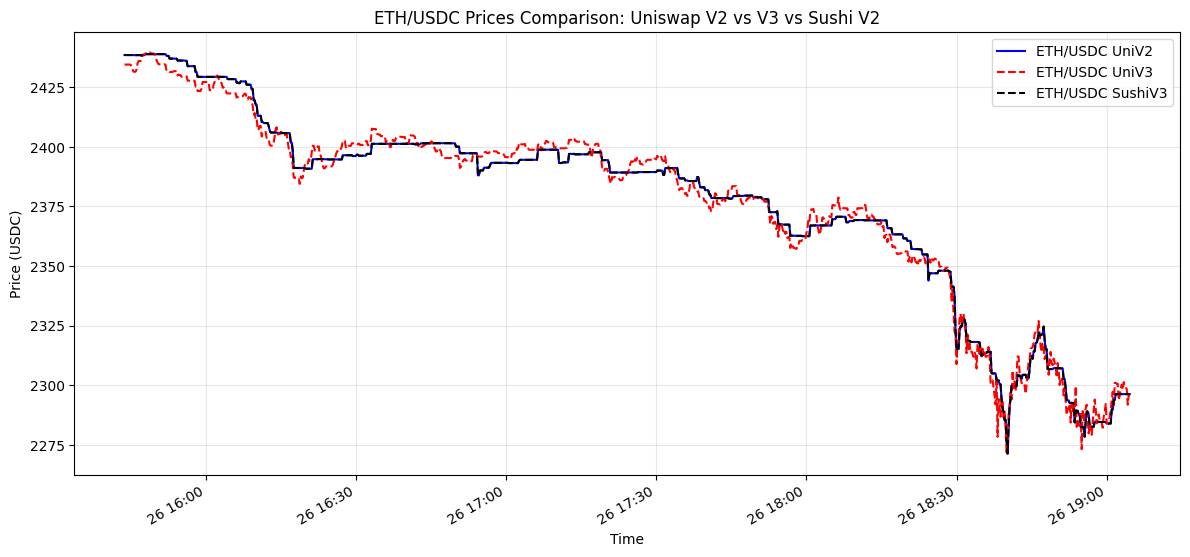

In [20]:
plt.figure(figsize=(12, 6))

# Plot both price series
df_prices['eth/usdc uniV2'].plot(label='ETH/USDC UniV2', color='blue')
df_prices['eth/usdc uniV3'].plot(label='ETH/USDC UniV3', color='red', linestyle='--')
df_prices['eth/usdc sushiV2'].plot(label='ETH/USDC SushiV3', color='black', linestyle='--')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Price (USDC)')
plt.title('ETH/USDC Prices Comparison: Uniswap V2 vs V3 vs Sushi V2')
plt.legend()
plt.grid(True, alpha=0.3)  # Add a light grid
plt.tight_layout()

# Format x-axis to show time better
plt.gcf().autofmt_xdate()  # Auto-format the date labels

plt.show()

In [21]:
df_prices.describe()

,eth/usdc uniV2,eth/usdc uniV3,eth/usdc sushiV2
count,1000.000000,1000.000000,1000.000000
mean,2377.264474,2376.917287,2377.264474
std,40.759296,40.489457,40.759296
min,2271.315745,2270.941860,2271.315745
25%,2363.284829,2360.638001,2363.284829
50%,2389.429805,2391.345989,2389.429805
75%,2401.046729,2401.290195,2401.046729
max,2438.864673,2439.717443,2438.864673


### Check Volatility 

In [22]:
#  Calc The changes and add columns
df_prices['vol_eth/usdc uniV2'] = df_prices['eth/usdc uniV2'].pct_change().abs() * 100
df_prices['vol_eth/usdc uniV3'] = df_prices['eth/usdc uniV3'].pct_change().abs() * 100
df_prices['vol_eth/usdc sushiV2'] = df_prices['eth/usdc sushiV2'].pct_change().abs() * 100

In [23]:
vol_eth_usdc_uniV2= df_prices['vol_eth/usdc uniV2'].std()
vol_eth_usdc_uniV3= df_prices['vol_eth/usdc uniV3'].std()
vol_eth_usdc_sushiV2= df_prices['vol_eth/usdc sushiV2'].std()

In [24]:
print(f"ETH/USDC UniV2: {vol_eth_usdc_uniV2:.4f}%")
print(f"ETH/USDC UniV3: {vol_eth_usdc_uniV3:.4f}%")
print(f"ETH/USDC SushiV2: {vol_eth_usdc_sushiV2:.4f}%")

ETH/USDC UniV2: 0.0620%
ETH/USDC UniV3: 0.0992%
ETH/USDC SushiV2: 0.0620%


## Test UniV3 Prices

In [50]:
usdc_eth_slot0_raw = aggregated_data_uniV2V3[1]

In [51]:
usdc_eth_slot0_raw

(True,
 b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00O\xab\x15\x91\xfb\x84\xef\xb3\xb0r,\xf4\xb9\x94\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x07F\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\xa0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\xd3\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\xd3\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01')

In [52]:
usdc_eth_slot0_sqrt_ratioX96 = decode(['uint160', 'int24', 'uint16', 'uint16', 'uint16', 'uint8', 'bool'], usdc_eth_slot0_raw[1])[0]

In [53]:
usdc_eth_slot0_sqrt_ratioX96

1615865050145637487349013352331668

In [54]:
usdc_eth_price = (usdc_eth_slot0_sqrt_ratioX96**2 / 2**192)/1e12

In [55]:
usdc_eth_price

0.00041595946192217004

In [56]:
1/usdc_eth_price

2404.080424998505

## Test UniV2 Prices

In [208]:
# To get them we will used binary format
decoded_data = decode(['(bool,bytes)[]'], output_data)[0]

In [209]:
reserves_data_uniV2

(11676567161113, 4726825701020660918420, 1740570683)

In [210]:
#  Arg of tryAggregate was get reserve: the eth_call output are the vaue of getReserves() in UNIV2
print("Reserves univ2:",int('a9ea9a34919',16),int('1003de253484b43e894', 16),int('67bf003b', 16))

Reserves univ2: 11676567161113 4726825701020660918420 1740570683


In [211]:
#  Call the function with data on reserves we get the price
decode_outputdata_uniV2_price(output_data)

ETH/USDC: 2429.380063025579
